### Tesla Closing Stock Price Prediction Using Random Forest 

##### Importing necessary libraries

In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler

##### Collecting Data with the help of yfinance

In [2]:
tsla_data = yf.download('TSLA', start='2015-01-01', end='2025-01-01')

[*********************100%***********************]  1 of 1 completed


##### Exploratory Data Analysis(EDA): Plotting Historical Stock Data

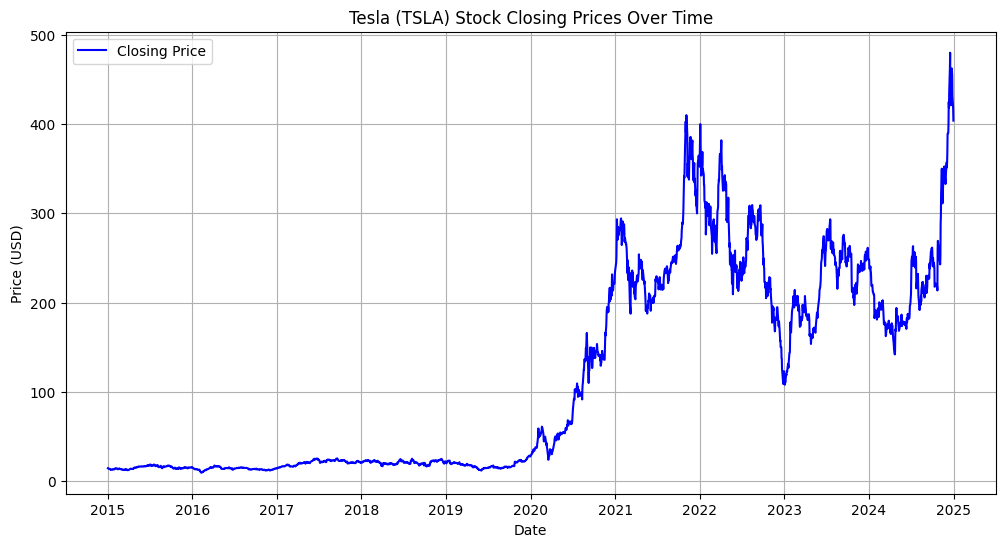

In [3]:
plt.figure(figsize=(12, 6))
plt.plot(tsla_data['Close'], label='Closing Price', color='blue')
plt.title('Tesla (TSLA) Stock Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid()
plt.show()

##### Analysis of Dataset

In [4]:
tsla_data.describe()

Price,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA
count,2516.000000,2516.000000,2516.000000,2516.000000,2.516000e+03
mean,115.679423,118.250154,112.986545,115.701436,1.123096e+08
std,114.226440,116.887822,111.485181,114.312114,7.406923e+07
min,9.578000,10.331333,9.403333,9.488000,1.062000e+07
25%,17.185167,17.481667,16.889166,17.177167,6.681885e+07
50%,28.505667,28.806000,27.349999,28.413666,9.284585e+07
75%,220.205002,225.354996,215.336670,220.925003,1.297886e+08
max,479.859985,488.540009,457.510010,475.899994,9.140820e+08


##### Feature Engineering (Adding moving averages (MA10 and MA50), Relative Strength Index(RSI) and Bollinger Bands)

In [13]:
tsla_data['MA10'] = tsla_data['Close'].rolling(window=10).mean()
tsla_data['MA50'] = tsla_data['Close'].rolling(window=50).mean()

# Add RSI (Relative Strength Index)
delta = tsla_data['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)

avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()

rs = avg_gain / avg_loss
tsla_data['RSI'] = 100 - (100 / (1 + rs))

# Add Bollinger Bands
tsla_data['Rolling_Mean'] = tsla_data['Close'].rolling(window=20).mean()
tsla_data['Rolling_Std'] = tsla_data['Close'].rolling(window=20).std()
tsla_data['Upper_BB'] = tsla_data['Rolling_Mean'] + (tsla_data['Rolling_Std'] * 2)
tsla_data['Lower_BB'] = tsla_data['Rolling_Mean'] - (tsla_data['Rolling_Std'] * 2)

# Drop rows with NaN values from newly added columns
tsla_data = tsla_data.dropna()

# Prepare features and target
features_advanced = tsla_data[['Open', 'High', 'Low', 'Volume', 'MA10', 'MA50', 'RSI', 'Upper_BB', 'Lower_BB']]
target_advanced = tsla_data['Close']

# Display updated data
# print(tsla_data.head())


##### Splitting data into Training and Testing sets

In [6]:
X_train_advanced, X_test_advanced, y_train_advanced, y_test_advanced = train_test_split(features_advanced, target_advanced, test_size=0.2, random_state=42)

##### Random Forest Model

In [7]:
# Initialize Random Forest Regressor and perform hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_model = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train_advanced, y_train_advanced)

# Best parameters and model
best_rf_model = grid_search.best_estimator_

# Make predictions
y_pred_rf = best_rf_model.predict(X_test_advanced)

# Evaluate the model
mae_rf = mean_absolute_error(y_test_advanced, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test_advanced, y_pred_rf))
print(f"Tuned Model - MAE: {mae_rf}, RMSE: {rmse_rf}")

y_test_advanced_flat = y_test_advanced.values.ravel()
y_pred_rf_flat = y_pred_rf.flatten()


Fitting 3 folds for each of 108 candidates, totalling 324 fits


c:\Users\Acer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Tuned Model - MAE: 1.695378972322069, RMSE: 3.3401418135184278


#### Random Forest Model Prediction Visualtization

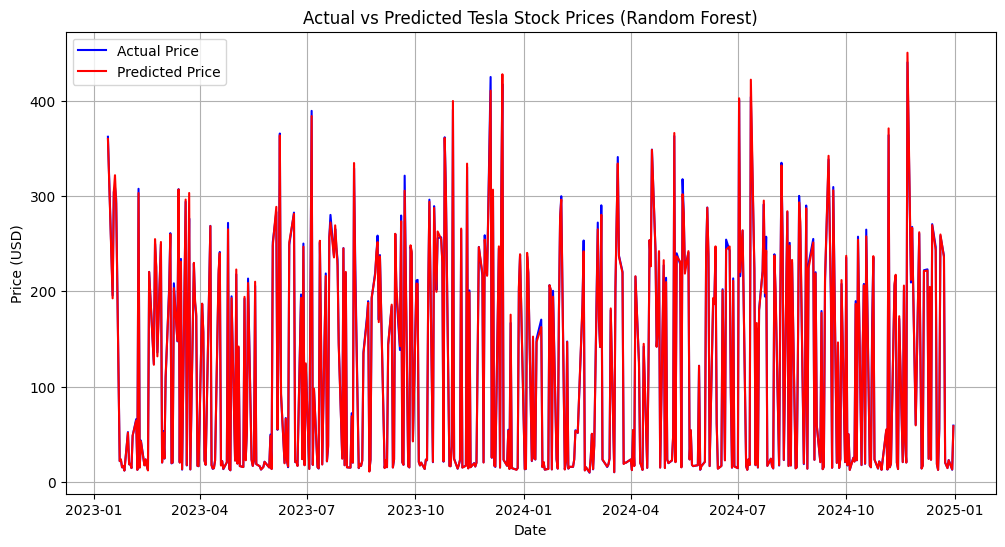

In [8]:
# Compare actual vs predicted prices for Random Forest model
rf_predictions_df = pd.DataFrame({
    'Date': tsla_data.index[-len(y_test_advanced):],
    'Actual Price': y_test_advanced_flat,
    'Predicted Price': y_pred_rf_flat
})

plt.figure(figsize=(12, 6))
plt.plot(rf_predictions_df['Date'], rf_predictions_df['Actual Price'], label='Actual Price', color='blue')
plt.plot(rf_predictions_df['Date'], rf_predictions_df['Predicted Price'], label='Predicted Price', color='red')
plt.title('Actual vs Predicted Tesla Stock Prices (Random Forest)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid()
plt.show()

##### Saving predictions to csv

In [9]:
rf_predictions_df.to_csv('TSLA_RF_Predictions.csv', index=False)

##### Calculating error MAE and RMSE for this model

In [10]:
mae_rf = mean_absolute_error(y_test_advanced, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test_advanced, y_pred_rf))

print(f"Random Forest Model - MAE: {mae_rf}, RMSE: {rmse_rf}")

Random Forest Model - MAE: 1.695378972322069, RMSE: 3.3401418135184278


##### Plot Distribution of Prediction Errors for Random Forest

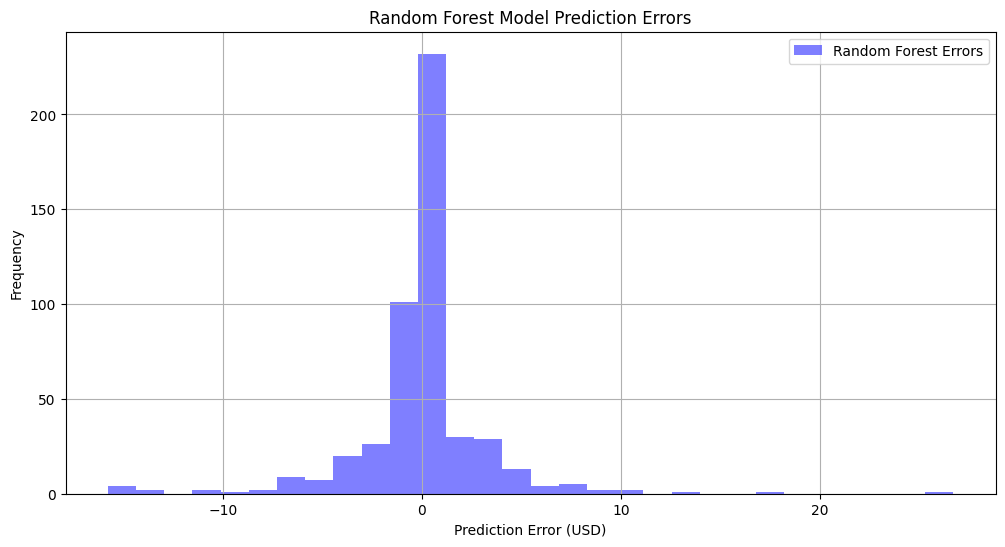

In [11]:
rf_errors = y_pred_rf_flat - y_test_advanced_flat

plt.figure(figsize=(12, 6))
plt.hist(rf_errors, bins=30, alpha=0.5, color='blue', label='Random Forest Errors')
plt.title('Random Forest Model Prediction Errors')
plt.xlabel('Prediction Error (USD)')
plt.ylabel('Frequency')
plt.legend()
plt.grid()
plt.show()

##### Statistical Analysis of Errors

In [12]:
comparison_metrics = pd.DataFrame({
    'Model': ['Random Forest'],
    'MAE': [mae_rf],
    'RMSE': [rmse_rf]
})

comparison_metrics

,Model,MAE,RMSE
0,Random Forest,1.695379,3.340142
